# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [1]:

import sys
import os
import glob
import warnings
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert, periodogram
from PyEMD import EMD, CEEMDAN

# regridding package
import xesmf as xe

# ACCESS-NRI intake catalogue
import intake

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## LOAD DATA (ARD)

In [2]:
dat = xr.open_dataset("/scratch/es60/ard/models/ACCESS-ESM15/ARD/ACCESS-ESM15-historical-Omon-thetao-chunk4time.zarr", engine="zarr").isel(lev=0)['thetao']
dat

<xarray.DataArray 'thetao' (member: 40, time: 1980, j: 300, i: 360)> Size: 34GB
[8553600000 values with dtype=float32]
Coordinates:
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
    latitude   (j, i) float64 864kB ...
    lev        float64 8B 5.0
    longitude  (j, i) float64 864kB ...
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
Dimensions without coordinates: member
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Diagnostic should be contributed even for models using co...
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    units:          degC

## quick look

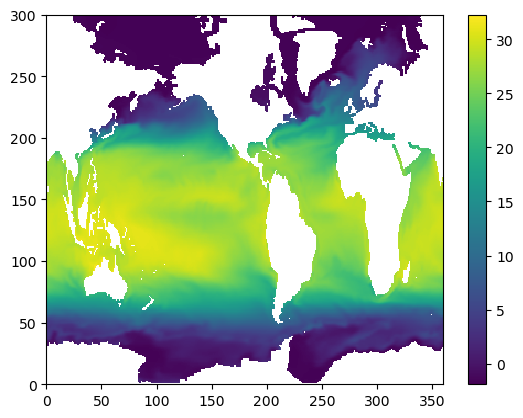

In [3]:
plt.figure()
plt.pcolormesh(dat.isel(member=0, time=0))
plt.colorbar()


## take climatology and anomaly

In [4]:
%%time

# Step 1: Calculate the climatology (mean for each month over all years)
sst_climatology = dat.groupby("time.month").mean("time")

# Step 2: Compute the anomaly by subtracting the climatology from the original data
sst_anomalies = dat.groupby("time.month") - sst_climatology
sst_anomalies


CPU times: user 10min 19s, sys: 8min 15s, total: 18min 34s
Wall time: 8min 23s


<xarray.DataArray 'thetao' (member: 40, time: 1980, j: 300, i: 360)> Size: 34GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    lev        (time) float64 16kB 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
    month      (time) int64 16kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: member

34.2144 GB


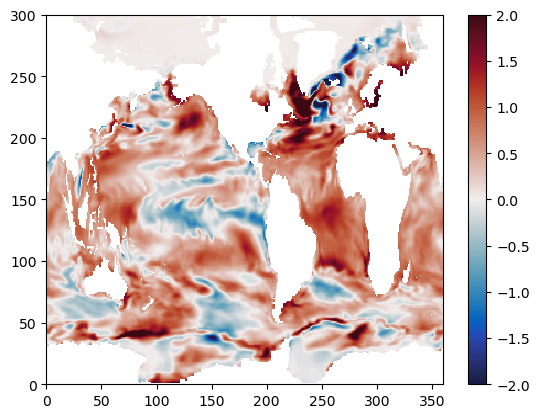

In [5]:
plt.figure()
plt.pcolormesh(sst_anomalies.isel(member=0, time=-1), cmap=cmo.balance, vmin=-2, vmax=2)
plt.colorbar()

print(sst_anomalies.nbytes / 1e9, "GB")  # Convert bytes to MB

## detrend the data

In [6]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

# Apply the function to each variable in the anomalies dataset
sst_detrended_anomalies = {}

for mem in sst_anomalies.coords['member'].values:
    var = "r%ii1p1f1"%(mem+1)
    print(f"Processing: {var}")  # Print the current variable name
    
    sst_detrended_anomalies[var] = xr.apply_ufunc(
        detrend_1d,
        sst_anomalies.isel(member=mem),  # Apply to each variable
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[sst_anomalies.isel(member=mem).dtype]
    )

# Convert dictionary back to an xarray Dataset
sst_detrended_anomalies = xr.Dataset(sst_detrended_anomalies)

# Check the detrended dataset
print(sst_detrended_anomalies)


Processing: r1i1p1f1
Processing: r2i1p1f1
Processing: r3i1p1f1
Processing: r4i1p1f1
Processing: r5i1p1f1
Processing: r6i1p1f1
Processing: r7i1p1f1
Processing: r8i1p1f1
Processing: r9i1p1f1
Processing: r10i1p1f1
Processing: r11i1p1f1
Processing: r12i1p1f1
Processing: r13i1p1f1
Processing: r14i1p1f1
Processing: r15i1p1f1
Processing: r16i1p1f1
Processing: r17i1p1f1
Processing: r18i1p1f1
Processing: r19i1p1f1
Processing: r20i1p1f1
Processing: r21i1p1f1
Processing: r22i1p1f1
Processing: r23i1p1f1
Processing: r24i1p1f1
Processing: r25i1p1f1
Processing: r26i1p1f1
Processing: r27i1p1f1
Processing: r28i1p1f1
Processing: r29i1p1f1
Processing: r30i1p1f1
Processing: r31i1p1f1
Processing: r32i1p1f1
Processing: r33i1p1f1
Processing: r34i1p1f1
Processing: r35i1p1f1
Processing: r36i1p1f1
Processing: r37i1p1f1
Processing: r38i1p1f1
Processing: r39i1p1f1
Processing: r40i1p1f1
<xarray.Dataset> Size: 34GB
Dimensions:    (i: 360, j: 300, time: 1980)
Coordinates:
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7

34.21617816 GB


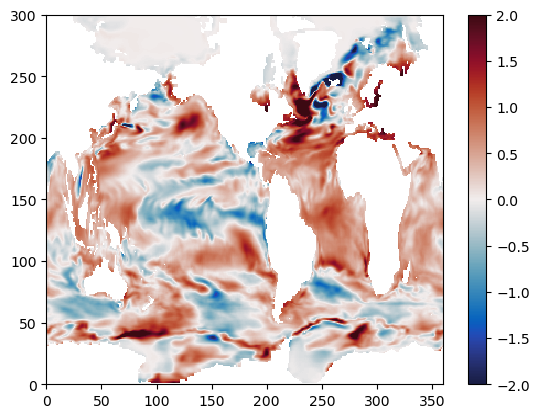

In [7]:
plt.figure()
plt.pcolormesh(sst_detrended_anomalies['r1i1p1f1'].isel(time=-1), cmap=cmo.balance, vmin=-2, vmax=2)
plt.colorbar()

print(sst_detrended_anomalies.nbytes / 1e9, "GB")  # Convert bytes to MB

## retrieve the linear least squares trend

In [8]:
%%time

# Create a dictionary to store trends for each variable
sst_trends = {}

# Get the time coordinate
dates = sst_anomalies.coords["time"]
time_length = len(dates)

for mem in sst_anomalies.coords['member'].values:
    var = "r%ii1p1f1"%(mem+1)
    print(f"Processing: {var}")  # Print the current variable name
   
    # Compute the trend for the current variable
    var_trend = sst_anomalies.isel(member=mem) - sst_detrended_anomalies[var]  # Trend component
    var_trend = (var_trend.sel(time=dates[-1]) - var_trend.sel(time=dates[0])) / time_length * 12 * 10  # Scale per decade

    # Store the trend in the dictionary
    sst_trends[var] = var_trend

# Convert the dictionary into an xarray Dataset
sst_trends = xr.Dataset(sst_trends)

# Print the final trends dataset
print(sst_trends)


Processing: r1i1p1f1
Processing: r2i1p1f1
Processing: r3i1p1f1
Processing: r4i1p1f1
Processing: r5i1p1f1
Processing: r6i1p1f1
Processing: r7i1p1f1
Processing: r8i1p1f1
Processing: r9i1p1f1
Processing: r10i1p1f1
Processing: r11i1p1f1
Processing: r12i1p1f1
Processing: r13i1p1f1
Processing: r14i1p1f1
Processing: r15i1p1f1
Processing: r16i1p1f1
Processing: r17i1p1f1
Processing: r18i1p1f1
Processing: r19i1p1f1
Processing: r20i1p1f1
Processing: r21i1p1f1
Processing: r22i1p1f1
Processing: r23i1p1f1
Processing: r24i1p1f1
Processing: r25i1p1f1
Processing: r26i1p1f1
Processing: r27i1p1f1
Processing: r28i1p1f1
Processing: r29i1p1f1
Processing: r30i1p1f1
Processing: r31i1p1f1
Processing: r32i1p1f1
Processing: r33i1p1f1
Processing: r34i1p1f1
Processing: r35i1p1f1
Processing: r36i1p1f1
Processing: r37i1p1f1
Processing: r38i1p1f1
Processing: r39i1p1f1
Processing: r40i1p1f1
<xarray.Dataset> Size: 19MB
Dimensions:    (i: 360, j: 300)
Coordinates:
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353

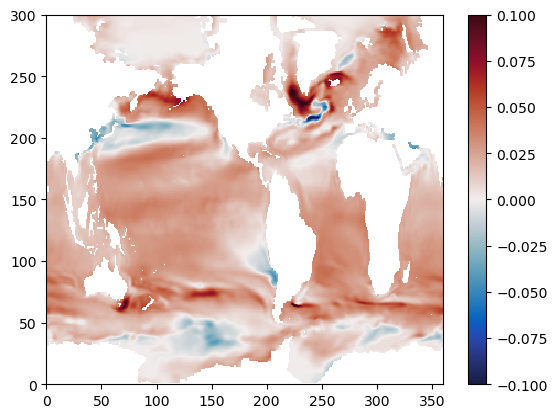

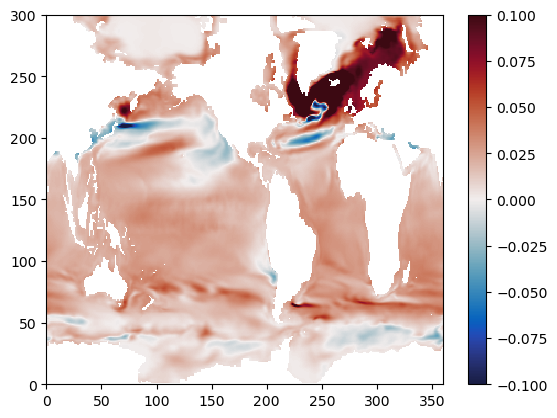

In [9]:
plt.figure()
plt.pcolormesh(sst_trends['r1i1p1f1'], cmap=cmo.balance, vmin=-0.1, vmax=0.1)
plt.colorbar()

plt.figure()
plt.pcolormesh(sst_trends['r2i1p1f1'], cmap=cmo.balance, vmin=-0.1, vmax=0.1)
plt.colorbar()


## Undertake the decomposition at each grid cell across the ocean

In [10]:
%%time

from joblib import Parallel, delayed
import signal

# Setup CEEMDAN config
def make_ceemdan():
    ceemdan = CEEMDAN()
    ceemdan.noise_seed = 42
    ceemdan.num_siftings = 50
    ceemdan.Nstd = 0.2
    ceemdan.trials = 25
    return ceemdan

# Setup
years = np.arange(1850+0.5/12, 2014+11.51/12, 1/12)
times = sst_anomalies.coords['time'].values
lats = sst_anomalies.coords['j'].values
lons = sst_anomalies.coords['i'].values
# Get the latitudes and longitudes (2D arrays)
lons_2d = sst_detrended_anomalies.coords["longitude"].values  # (j, i)
lats_2d = sst_detrended_anomalies.coords["latitude"].values  # (j, i)


def find_imf_freq_Hilbert(imfs, years):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])

def find_weights_from_freqs(imfs, bands):
    fs = 12  # Hz (cycles per year)
    n_imfs, n_time = imfs.shape
    n_bands = len(bands)
    weights = np.zeros((n_bands, n_imfs))
    # find the frequency power spectra of the different IMFs
    freqs = []
    power = []
    for i in range(n_imfs):
        f, p = periodogram(imfs[i,:], fs=fs, scaling='density', window='hann')
        freqs.append(f)
        power.append(p)
    freqs = np.array(freqs); power = np.array(power)
    # find the weights associated with that power spectra
    for i in range(n_imfs):
        total_power = np.sum(power[i,:])
        for j, (f_min, f_max) in enumerate(bands):
            mask = (freqs[i,:] >= f_min) & (freqs[i,:] < f_max)
            band_power = np.sum(power[i][mask])
            weights[j, i] = band_power / total_power if total_power > 0 else 0.0
    return weights

def set_bands(imfs, weights):
    return weights @ imfs

# Processing function for each grid cell
def process_cell(ix, iy, var):
    ceemdan = make_ceemdan()  # Create fresh CEEMDAN instance (safe in parallel)
    signal = sst_detrended_anomalies[var].isel(i=ix, j=iy).values
    if not np.all(np.isfinite(signal)) or np.all(signal == 0.0) or np.any(np.isnan(signal)):
        return (ix, iy, None)
    try:
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        imfs = ceemdan(signal)
        weights = find_weights_from_freqs(imfs, bands)
        grouped = set_bands(imfs, weights)
        return (ix, iy, grouped)
    except Exception as e:
        print(f"Error at ({ix}, {iy}): {e}")
        return (ix, iy, None)


CPU times: user 695 μs, sys: 0 ns, total: 695 μs
Wall time: 386 μs


In [45]:
%%time

mem = 0
var = "r1i1p1f1"
print(f"Processing variable: {var}")

# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

nlat = len(lats)
nlon = len(lons)
sst_imfs = np.zeros((4, len(times), nlat, nlon))
years = np.arange(1850+0.5/12, 2014+11.51/12, 1/12)
lons_2d = sst_detrended_anomalies.coords["longitude"].values
lats_2d = sst_detrended_anomalies.coords["latitude"].values
ix = 250
iy = 120
print(f"Latitude {lats_2d[iy,ix]} and longitude {lons_2d[iy,ix]}")

out = process_cell(ix, iy, var)


Processing variable: r1i1p1f1
Latitude -5.499542713165283 and longitude 330.5
CPU times: user 3.18 s, sys: 0 ns, total: 3.18 s
Wall time: 3.18 s


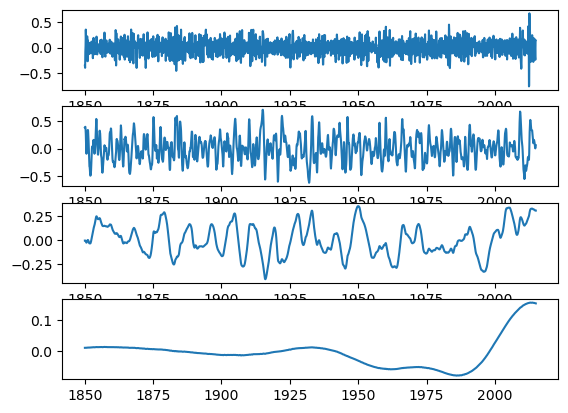

In [46]:
plt.figure()
gs = GridSpec(4,1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

ax1.plot(years, out[2][0,:])
ax2.plot(years, out[2][1,:])
ax3.plot(years, out[2][2,:])
ax4.plot(years, out[2][3,:])


In [47]:
%%time

# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

# Coordinate pairs
ntime = len(times)
nlat = len(lats)
nlon = len(lons)
coords = [(ix, iy) for ix in range(nlon) for iy in range(nlat)]

results = Parallel(n_jobs=112, backend='loky', verbose=10)(
    delayed(process_cell)(ix, iy, var) for ix, iy in coords
)


[Parallel(n_jobs=112)]: Using backend LokyBackend with 112 concurrent workers.
[Parallel(n_jobs=112)]: Done  18 tasks      | elapsed:   42.9s
[Parallel(n_jobs=112)]: Done  41 tasks      | elapsed:   48.3s
[Parallel(n_jobs=112)]: Done  64 tasks      | elapsed:   51.5s
[Parallel(n_jobs=112)]: Done  89 tasks      | elapsed:   53.3s
[Parallel(n_jobs=112)]: Done 114 tasks      | elapsed:   53.9s
[Parallel(n_jobs=112)]: Done 141 tasks      | elapsed:   54.5s
[Parallel(n_jobs=112)]: Done 168 tasks      | elapsed:   55.2s
[Parallel(n_jobs=112)]: Done 197 tasks      | elapsed:   55.9s
[Parallel(n_jobs=112)]: Done 226 tasks      | elapsed:   56.6s
[Parallel(n_jobs=112)]: Done 257 tasks      | elapsed:   57.6s
[Parallel(n_jobs=112)]: Done 288 tasks      | elapsed:  1.1min
[Parallel(n_jobs=112)]: Done 321 tasks      | elapsed:  1.2min
[Parallel(n_jobs=112)]: Done 354 tasks      | elapsed:  1.2min
[Parallel(n_jobs=112)]: Done 389 tasks      | elapsed:  1.3min
[Parallel(n_jobs=112)]: Done 424 tasks 

CPU times: user 11min 14s, sys: 2min 9s, total: 13min 23s
Wall time: 2h 28min 25s


In [52]:
%%time

sst_imfs = np.zeros((4, len(times), nlat, nlon))

for ix, iy, grouped in results:
    if grouped is not None:
        sst_imfs[:, :, iy, ix] = grouped

# Save results to xarray Dataset
name1 = f"{var}_sst_imfs"
name2 = f"{var}_sst_anom"
name3 = f"{var}_sst_detr"
name4 = f"{var}_sst_trend"

# Create xarray Datasets
imfs_sst_ds = xr.Dataset(
    {
        name1: (["IMF", "time", "j", "i"], sst_imfs),
        name2: (["time", "j", "i"], sst_anomalies.isel(member=mem).values),
        name3: (["time", "j", "i"], sst_detrended_anomalies[var].transpose("time", "j", "i").values),
        name4: (["j", "i"], sst_trends[var].values),
    },
    coords={
        "IMF": np.arange(1,5,1),
        "time": times,
        "j": lats,
        "i": lons,
        "longitude": (["j", "i"], lons_2d),
        "latitude": (["j", "i"], lats_2d),
    },
)
os.chdir(wrkdir + "/data/")
#os.remove(f"{var}_chl_imfs_CEEMDAN.nc")
imfs_sst_ds.to_netcdf(f"{var}_sst_imfs_CEEMDAN.nc")


CPU times: user 13 s, sys: 15 s, total: 28 s
Wall time: 54.9 s


In [ ]:
%%time

# === Set up grid and run over variables ===
import warnings 

# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

years = np.arange(1850+0.5/12, 2014+11.51/12, 1/12)
times = sst_anomalies.coords['time'].values
lats = sst_anomalies.coords['j'].values
lons = sst_anomalies.coords['i'].values
lons_2d = sst_detrended_anomalies.coords["longitude"].values
lats_2d = sst_detrended_anomalies.coords["latitude"].values

nlat = len(lats)
nlon = len(lons)

save_dir = "/g/data/es60/pjb581/SPC/data/"

for mem, var in enumerate(sst_detrended_anomalies.data_vars.keys()):
    if mem < 28:
        continue
    
    print(f"Processing variable: {var}")
    coords = [(ix, iy) for ix in range(nlon) for iy in range(nlat)]
    results = Parallel(n_jobs=224, backend='loky', verbose=1)(
        delayed(process_cell)(ix, iy, var) for ix, iy in coords
    )
    sst_imfs = np.zeros((4, len(times), nlat, nlon))
    for ix, iy, grouped in results:
        if grouped is not None:
            sst_imfs[:, :, iy, ix] = grouped
    
    # Save results to xarray Dataset
    name1 = f"{var}_sst_imfs"
    name2 = f"{var}_sst_anom"
    name3 = f"{var}_sst_detr"
    name4 = f"{var}_sst_trend"

    imf_da = xr.Dataset(
        {
            name1: (["IMF", "time", "j", "i"], sst_imfs),
            name2: (["time", "j", "i"], sst_anomalies.isel(member=mem).values),
            name3: (["time", "j", "i"], sst_detrended_anomalies[var].transpose("time", "j", "i").values),
            name4: (["j", "i"], sst_trends[var].values),
        },
        coords={
            "IMF": np.arange(1, 5),
            "time": times,
            "j": lats,
            "i": lons,
            "longitude": (["j", "i"], lons_2d),
            "latitude": (["j", "i"], lats_2d),
        },
    )

    file_name = f"{var}_sst_imfs_CEEMDAN.nc"
    file_path = os.path.join(save_dir, file_name)
    imf_da.to_netcdf(file_path)
    print(f"Saved {file_name}")

print("✅ Finished processing all variables.")


Processing variable: r29i1p1f1


[Parallel(n_jobs=224)]: Using backend LokyBackend with 224 concurrent workers.
[Parallel(n_jobs=224)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=224)]: Done 352 tasks      | elapsed:  2.7min
[Parallel(n_jobs=224)]: Done 802 tasks      | elapsed:  3.2min
[Parallel(n_jobs=224)]: Done 1352 tasks      | elapsed:  3.8min
[Parallel(n_jobs=224)]: Done 2002 tasks      | elapsed:  4.5min
[Parallel(n_jobs=224)]: Done 2752 tasks      | elapsed:  5.3min
[Parallel(n_jobs=224)]: Done 3602 tasks      | elapsed:  6.2min
[Parallel(n_jobs=224)]: Done 4552 tasks      | elapsed:  7.2min
[Parallel(n_jobs=224)]: Done 5602 tasks      | elapsed:  8.2min
[Parallel(n_jobs=224)]: Done 6752 tasks      | elapsed:  9.0min
[Parallel(n_jobs=224)]: Done 8002 tasks      | elapsed: 10.2min
[Parallel(n_jobs=224)]: Done 9352 tasks      | elapsed: 11.5min
[Parallel(n_jobs=224)]: Done 10802 tasks      | elapsed: 12.9min
[Parallel(n_jobs=224)]: Done 12352 tasks      | elapsed: 14.4min
[Parallel(n_jobs=224)]: Do

Saved r29i1p1f1_sst_imfs_CEEMDAN.nc
Processing variable: r30i1p1f1


[Parallel(n_jobs=224)]: Using backend LokyBackend with 224 concurrent workers.
[Parallel(n_jobs=224)]: Done   2 tasks      | elapsed:   21.1s
[Parallel(n_jobs=224)]: Done 352 tasks      | elapsed:   42.3s
[Parallel(n_jobs=224)]: Done 802 tasks      | elapsed:  1.2min
[Parallel(n_jobs=224)]: Done 1352 tasks      | elapsed:  1.7min
[Parallel(n_jobs=224)]: Done 2002 tasks      | elapsed:  2.5min
[Parallel(n_jobs=224)]: Done 2752 tasks      | elapsed:  3.3min
[Parallel(n_jobs=224)]: Done 3602 tasks      | elapsed:  4.2min
[Parallel(n_jobs=224)]: Done 4552 tasks      | elapsed:  5.1min
[Parallel(n_jobs=224)]: Done 5602 tasks      | elapsed:  6.1min
[Parallel(n_jobs=224)]: Done 6752 tasks      | elapsed:  7.0min
[Parallel(n_jobs=224)]: Done 8002 tasks      | elapsed:  8.1min
[Parallel(n_jobs=224)]: Done 9352 tasks      | elapsed:  9.4min
[Parallel(n_jobs=224)]: Done 10802 tasks      | elapsed: 10.8min
[Parallel(n_jobs=224)]: Done 12352 tasks      | elapsed: 12.4min
[Parallel(n_jobs=224)]: Do

## try another way, with parallelisation over the members

In [14]:
%%time

from joblib import Parallel, delayed

def process_member(mem, var, coords, sst_detrended_anomalies, sst_anomalies, sst_trends, lons_2d, lats_2d, years, times, lats, lons, save_dir):
    import os
    import numpy as np
    import xarray as xr
    import warnings
    from pyemd import CEEMDAN
    from scipy.signal import hilbert

    # Redefine core functions inside to ensure they are available in each process
    def make_ceemdan():
        ceemdan = CEEMDAN()
        ceemdan.noise_seed = 42
        ceemdan.num_siftings = 50
        ceemdan.Nstd = 0.1
        ceemdan.trials = 20
        return ceemdan

    def find_imf_freq(imfs, years):
        inst_freqs = []
        for imf in imfs:
            analytic_signal = hilbert(imf)
            phase = np.unwrap(np.angle(analytic_signal))
            freq = np.diff(phase) / (2.0 * np.pi * np.diff(years))
            inst_freqs.append(freq)
        return np.array([np.mean(f) for f in inst_freqs])

    def set_imfs(imfs, freqs):
        if imfs.shape[0] > 0:
            mask1 = freqs > 1
            mask2 = (freqs <= 1) & (freqs > 0.2)
            mask3 = (freqs <= 0.2) & (freqs > 0.0)
            out1 = np.mean(imfs[mask1], axis=0) if np.any(mask1) else np.zeros_like(imfs[0])
            out2 = np.mean(imfs[mask2], axis=0) if np.any(mask2) else np.zeros_like(imfs[0])
            out3 = np.mean(imfs[mask3], axis=0) if np.any(mask3) else np.zeros_like(imfs[0])
        else:
            out1 = out2 = out3 = np.zeros(len(imfs[0]))
        return np.array([out1, out2, out3])

    def process_grid_point(ix, iy):
        ts = sst_detrended_anomalies[var].isel(i=ix, j=iy).values
        if np.any(np.isnan(ts)):
            return (ix, iy, np.zeros((3, len(ts))))
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=RuntimeWarning)
                ceemdan = make_ceemdan()
                imfs = ceemdan(ts, max_imf=5)
                freqs = find_imf_freq(imfs, years)
                grouped = set_imfs(imfs, freqs)
            return (ix, iy, grouped)
        except Exception as e:
            print(f"Error at ({ix},{iy}): {e}")
            return (ix, iy, np.zeros((3, len(ts))))

    nlat = len(lats)
    nlon = len(lons)
    sst_imfs = np.zeros((3, len(times), nlat, nlon))

    results = Parallel(n_jobs=28, backend="loky", verbose=10)(
        delayed(process_grid_point)(ix, iy) for ix, iy in coords
    )

    for ix, iy, grouped in results:
        sst_imfs[:, :, iy, ix] = grouped

    name1 = f"{var}_sst_imfs"
    name2 = f"{var}_sst_anom"
    name3 = f"{var}_sst_detr"
    name4 = f"{var}_sst_trend"

    imf_da = xr.Dataset(
        {
            name1: (["IMF", "time", "j", "i"], sst_imfs),
            name2: (["time", "j", "i"], sst_anomalies.isel(member=mem).values),
            name3: (["time", "j", "i"], sst_detrended_anomalies[var].transpose("time", "j", "i").values),
            name4: (["j", "i"], sst_trends[var].values),
        },
        coords={
            "IMF": np.arange(1, 4),
            "time": times,
            "j": lats,
            "i": lons,
            "longitude": (["j", "i"], lons_2d),
            "latitude": (["j", "i"], lats_2d),
        },
    )

    file_name = f"{var}_sst_imfs.nc"
    file_path = os.path.join(save_dir, file_name)
    imf_da.to_netcdf(file_path)
    return var, file_name


CPU times: user 22 μs, sys: 11 μs, total: 33 μs
Wall time: 40.3 μs


In [16]:
members_to_process = list(enumerate(list(sst_detrended_anomalies.data_vars.keys())))
print(members_to_process[5:])

[(5, 'r6i1p1f1'), (6, 'r7i1p1f1'), (7, 'r8i1p1f1'), (8, 'r9i1p1f1'), (9, 'r10i1p1f1'), (10, 'r11i1p1f1'), (11, 'r12i1p1f1'), (12, 'r13i1p1f1'), (13, 'r14i1p1f1'), (14, 'r15i1p1f1'), (15, 'r16i1p1f1'), (16, 'r17i1p1f1'), (17, 'r18i1p1f1'), (18, 'r19i1p1f1'), (19, 'r20i1p1f1'), (20, 'r21i1p1f1'), (21, 'r22i1p1f1'), (22, 'r23i1p1f1'), (23, 'r24i1p1f1'), (24, 'r25i1p1f1'), (25, 'r26i1p1f1'), (26, 'r27i1p1f1'), (27, 'r28i1p1f1'), (28, 'r29i1p1f1'), (29, 'r30i1p1f1'), (30, 'r31i1p1f1'), (31, 'r32i1p1f1'), (32, 'r33i1p1f1'), (33, 'r34i1p1f1'), (34, 'r35i1p1f1'), (35, 'r36i1p1f1'), (36, 'r37i1p1f1'), (37, 'r38i1p1f1'), (38, 'r39i1p1f1'), (39, 'r40i1p1f1')]


In [ ]:
%%time

from concurrent.futures import ProcessPoolExecutor, as_completed

years = np.arange(1850+0.5/12, 2014+11.51/12, 1/12)
times = sst_anomalies.coords['time'].values
lats = sst_anomalies.coords['j'].values
lons = sst_anomalies.coords['i'].values
lons_2d = sst_detrended_anomalies.coords["longitude"].values
lats_2d = sst_detrended_anomalies.coords["latitude"].values
nlat = len(lats)
nlon = len(lons)

save_dir = "/g/data/es60/pjb581/SPC/data/"
imf_results = {}

# Coordinates for all grid cells
coords = [(ix, iy) for iy in range(nlat) for ix in range(nlon)]

# Which variables (ensemble members) to process
members_to_process = list(enumerate(list(sst_detrended_anomalies.data_vars.keys())))

# How many members to run concurrently
max_parallel_members = 4  # 4 members × 28 CPUs = 112 total

print(f"Starting parallel processing of {len(members_to_process)} ensemble members using {max_parallel_members} concurrent jobs...")

with ProcessPoolExecutor(max_workers=max_parallel_members) as executor:
    futures = [
        executor.submit(
            process_member,
            mem, var, coords,
            sst_detrended_anomalies,
            sst_anomalies,
            sst_trends,
            lons_2d,
            lats_2d,
            years,
            times,
            lats,
            lons,
            save_dir
        )
        for mem, var in members_to_process[5:]
    ]

    for future in as_completed(futures):
        try:
            var, file_name = future.result()
            print(f"✅ Completed {var}, saved to {file_name}")
        except Exception as e:
            print(f"❌ Error while processing a member: {e}")

print("🎉 All requested ensemble members have been processed.")


Starting parallel processing of 40 ensemble members using 4 concurrent jobs...
